## Подключение зависимостей

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import defaultdict

In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)

## Данные

In [ ]:
data = pd.read_csv("gym_members_exercise_tracking.csv")
data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


<Axes: >

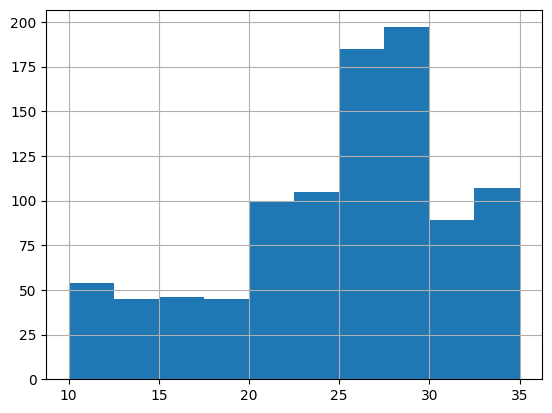

In [ ]:
data.Fat_Percentage.hist()

In [ ]:
label_encoder = LabelEncoder()

data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Workout_Type'] = label_encoder.fit_transform(data['Workout_Type'])
data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,3,12.6,3.5,4,3,30.20
1,46,0,74.9,1.53,179,151,66,1.30,883.0,1,33.9,2.1,4,2,32.00
2,32,0,68.1,1.66,167,122,54,1.11,677.0,0,33.4,2.3,4,2,24.71
3,25,1,53.2,1.70,190,164,56,0.59,532.0,2,28.8,2.1,3,1,18.41
4,38,1,46.1,1.79,188,158,68,0.64,556.0,2,29.2,2.8,3,1,14.39


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    int64  
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    int64  
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [ ]:
X, y = data[['Gender', 'Workout_Type']], data['Experience_Level']
X['Workout_Type'] = X['Workout_Type'] < 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<ipython-input-43-4471c879c0eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Workout_Type'] = X['Workout_Type'] < 2


In [ ]:
def ensure_numeric(array):
    return np.array(array, dtype=np.float64)

X_train = ensure_numeric(X_train)
X_test = ensure_numeric(X_test)

### Наивный Байес

In [ ]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.class_priors = {}
        self.means = {}
        self.variances = {}

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.classes = np.unique(y)

        for cls in self.classes:
            X_cls = X[y == cls]
            self.class_priors[cls] = X_cls.shape[0] / X.shape[0]
            self.means[cls] = X_cls.mean(axis=0)
            self.variances[cls] = X_cls.var(axis=0, ddof=1) + 1e-9

    def _gaussian_pdf(self, x, mean, var):
        return np.exp(-(x - mean)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)

    def predict(self, X):
        X = np.array(X)
        predictions = []

        for sample in X:
            max_log_prob = -np.inf
            best_class = None

            for cls in self.classes:
                log_prob = np.log(self.class_priors[cls])
                log_prob += np.sum(np.log(self._gaussian_pdf(sample, self.means[cls], self.variances[cls])))

                if log_prob > max_log_prob:
                    max_log_prob = log_prob
                    best_class = cls

            predictions.append(best_class)

        return np.array(predictions)

In [ ]:
nb = GaussianNaiveBayes()
nb.fit(X_train, y_train)

In [ ]:
y_pred = nb.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.17


In [ ]:
class BernoulliNaiveBayes:
    def init(self):
        self.classes = None
        self.class_priors = None
        self.bernoulli_probs = None
        self._is_fitted = False

    def fit(self, X, y):
        self.classes, counts = np.unique(y, return_counts=True)
        self.class_priors = (counts + self.alpha) / (len(y) + self.alpha * len(self.classes))

        n_features = X.shape[1]
        self.bernoulli_probs = defaultdict(dict)

        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            for feature in range(n_features):
                count_1 = np.sum(X_cls[:, feature]) + self.alpha
                total = X_cls.shape[0] + 2 * self.alpha
                self.bernoulli_probs[cls][feature] = count_1 / total

        self._is_fitted = True

    def predict(self, X):
        if not self._is_fitted:
            raise ValueError("Call fit() before predict()")

        log_probs = []
        for cls in self.classes:
            class_log_prob = np.log(self.class_priors[i])
            feature_log_probs = [
                np.where(X[:, i] == 1,
                         np.log(self.bernoulli_probs[cls][i]),
                         np.log(1 - self.bernoulli_probs[cls][i]))
                for i in range(X.shape[1])
            ]
            log_probs.append(class_log_prob + np.sum(feature_log_probs, axis=0))

        return self.classes[np.argmax(log_probs, axis=0)]

In [ ]:
bnb = BernoulliNaiveBayes()
bnb.fit(X_train, y_train)

In [ ]:
accuracy = accuracy_score(y_test, bnb.predict(X_test))
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.21


### Библиотечная версия

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        89
           1       0.97      0.80      0.88       106

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.89      0.88      0.88       195

Confusion Matrix:
[[86  3]
 [21 85]]
